<a href="https://colab.research.google.com/github/lds2125/iot-spr3/blob/main/motorcycle_detection_parking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção e Rastreamento de Motocicletas com YOLOv8 no Google Colab (Simulação Sintética)

Este notebook demonstra a detecção e o rastreamento de motocicletas em um ambiente simulado, gerando frames sintéticos com motocicletas em movimento. Isso elimina a necessidade de webcam ou vídeos pré-gravados, permitindo testar a funcionalidade de visão computacional de forma controlada e reprodutível. O objetivo é focar na detecção visual de motocicletas em um fluxo de vídeo em tempo real simulado.

## 1. Configuração do Ambiente

Primeiro, precisamos instalar as bibliotecas necessárias: `ultralytics` para o YOLOv8 e `opencv-python` para processamento de imagem. **É crucial executar a célula abaixo antes de qualquer outra célula de código para garantir que as dependências estejam instaladas.** Certifique-se de que o ambiente de execução do Colab está configurado para usar GPU (Runtime -> Change runtime type -> T4 GPU).

In [1]:
!pip install ultralytics opencv-python
from IPython.display import clear_output
clear_output() # Limpa a saída da instalação para manter o notebook limpo
print("Dependências instaladas com sucesso!")

Dependências instaladas com sucesso!


## 2. Geração de Frames Sintéticos com Motocicletas em Movimento

Esta seção implementa a lógica para gerar frames de vídeo com múltiplos objetos (simulando motocicletas) se movendo em um cenário simples. Isso nos permite testar o modelo YOLOv8 sem a necessidade de uma fonte de vídeo externa.

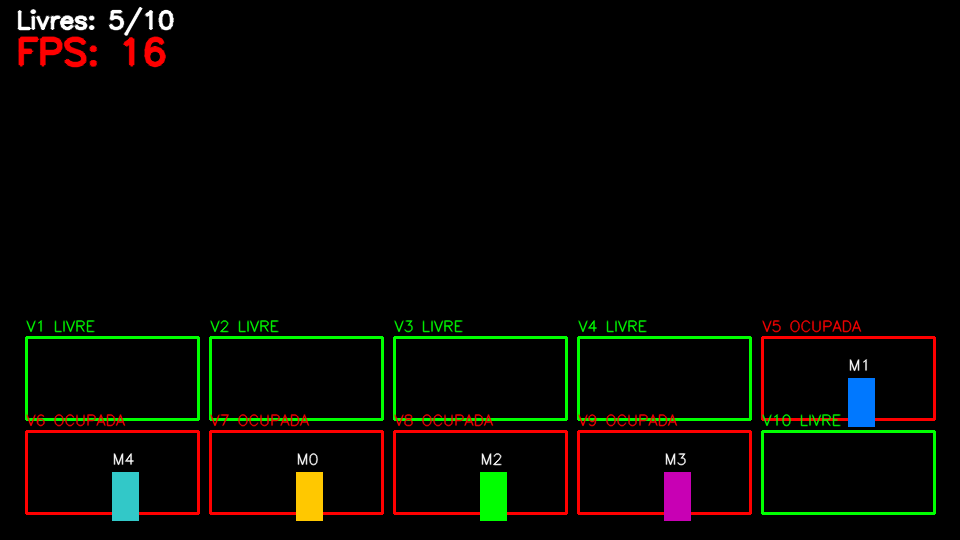

Iniciando simulação. Tecle Stop/Interromper para encerrar.
Simulação interrompida pelo usuário.
Simulação finalizada.


In [6]:

import math, random, time
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import cv2

from IPython.display import display
from PIL import Image

@dataclass
class Vaga:
    id: int
    x1: int; y1: int; x2: int; y2: int
    ocupada: bool = False
    ocupante: int | None = None
    def centro(self) -> Tuple[int, int]:
        return ((self.x1+self.x2)//2, (self.y1+self.y2)//2)
    def contem(self, x: int, y: int) -> bool:
        return self.x1 <= x <= self.x2 and self.y1 <= y <= self.y2

def criar_vagas(W: int, H: int, cols: int = 5, rows: int = 2, pad: int = 20) -> List[Vaga]:
    vagas = []
    grid_w = W - 2*pad
    grid_h = int(H*0.35)
    cell_w = grid_w // cols
    cell_h = grid_h // rows
    y_top = H - grid_h - pad
    vid = 1
    for r in range(rows):
        for c in range(cols):
            x1 = pad + c*cell_w + 6
            y1 = y_top + r*cell_h + 6
            x2 = x1 + cell_w - 12
            y2 = y1 + cell_h - 12
            vagas.append(Vaga(vid, x1, y1, x2, y2))
            vid += 1
    return vagas

def desenhar_vagas(frame: np.ndarray, vagas: List[Vaga]) -> None:
    for v in vagas:
        cor = (0,255,0) if not v.ocupada else (0,0,255)
        cv2.rectangle(frame, (v.x1, v.y1), (v.x2, v.y2), cor, 2)
        cv2.putText(frame, f"V{v.id} {'LIVRE' if not v.ocupada else 'OCUPADA'}",
                    (v.x1, max(18, v.y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 1, cv2.LINE_AA)

def inicializar_motos(W: int, H: int, qtd: int):
    motos = []
    for _ in range(qtd):
        side = random.choice(["left","right","top","right"])
        if side == "left":
            x, y = 0, random.randint(40, H//2); vx, vy = random.uniform(2,4), random.uniform(0.2,1.0)
        elif side == "right":
            x, y = W-1, random.randint(40, H//2); vx, vy = -random.uniform(2,4), random.uniform(0.2,1.0)
        else:
            x, y = random.randint(20, W-20), 0; vx, vy = random.uniform(-1,1), random.uniform(2,3.5)
        motos.append({"x": float(x), "y": float(y), "vx": vx, "vy": vy, "state": "approach", "slot": None})
    return motos

def atribuir_vagas(motos, vagas):
    livres = [v for v in vagas if not v.ocupada and v.ocupante is None]
    random.shuffle(livres)
    for m in motos:
        if m["slot"] is None and livres:
            v = livres.pop()
            m["slot"] = v.id

def atualizar_motos(motos, vagas):
    for idx, m in enumerate(motos):
        if m["slot"] is None:
            atribuir_vagas([m], vagas)
        alvo = next((v for v in vagas if v.id == m["slot"]), None)
        if alvo is None:
            continue
        tx, ty = alvo.centro()

        if m["state"] == "approach":
            dx, dy = tx - m["x"], ty - m["y"]
            dist = math.hypot(dx, dy) + 1e-6
            m["vx"] = 0.92*m["vx"] + 0.08*(dx/dist)*4.0
            m["vy"] = 0.92*m["vy"] + 0.08*(dy/dist)*4.0
            m["x"] += m["vx"]; m["y"] += m["vy"]
            if dist < 60:
                m["state"] = "align"

        elif m["state"] == "align":
            dx, dy = tx - m["x"], ty - m["y"]
            dist = math.hypot(dx, dy) + 1e-6
            m["vx"] = 0.85*m["vx"] + 0.15*(dx/dist)*2.0
            m["vy"] = 0.85*m["vy"] + 0.15*(dy/dist)*2.0
            m["x"] += m["vx"]; m["y"] += m["vy"]
            if dist < 12:
                m["state"] = "park"

        elif m["state"] == "park":
            m["vx"] *= 0.6; m["vy"] *= 0.6
            m["x"] += m["vx"]; m["y"] += m["vy"]
            if abs(m["vx"]) + abs(m["vy"]) < 0.12:
                m["state"] = "parked"
                m["x"], m["y"] = tx, ty

        else:
            m["vx"] = m["vy"] = 0.0
            m["x"], m["y"] = tx, ty

    for v in vagas:
        v.ocupada = False
        v.ocupante = None
        for i, m in enumerate(motos):
            if v.contem(int(m["x"]), int(m["y"])) and m["state"] in ("park","parked"):
                v.ocupada = True
                v.ocupante = i
                break

def desenhar_motos(frame: np.ndarray, motos) -> None:
    w, h = 26, 48
    cores = [(0,200,255),(255,120,0),(0,255,0),(180,0,200),(200,200,50),(255,0,128)]
    for i, m in enumerate(motos):
        x, y = int(m["x"]), int(m["y"])
        x = max(0, min(frame.shape[1]-w-1, x))
        y = max(0, min(frame.shape[0]-h-1, y))
        cor = cores[i % len(cores)]
        cv2.rectangle(frame, (x, y), (x+w, y+h), cor, -1)
        cv2.putText(frame, f"M{i}", (x, y-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

W, H = 960, 540
N_MOTOS = 5
COLS, ROWS = 5, 2
DURACAO_S = 30
TARGET_FPS = 24

vagas = criar_vagas(W, H, cols=COLS, rows=ROWS, pad=20)
motos = inicializar_motos(W, H, N_MOTOS)
atribuir_vagas(motos, vagas)

img_init = Image.new('RGB', (W, H))
display_handle = display(img_init, display_id=True)

print("Iniciando simulação. Tecle Stop/Interromper para encerrar.")
start_t = time.time()
prev_t = start_t
fps_ema = TARGET_FPS * 0.5

try:
    while True:
        now = time.time()
        if now - start_t > DURACAO_S:
            break

        frame = np.zeros((H, W, 3), dtype=np.uint8)

        atualizar_motos(motos, vagas)
        desenhar_vagas(frame, vagas)
        desenhar_motos(frame, motos)

        livres = sum(1 for v in vagas if not v.ocupada)
        cv2.putText(frame, f"Livres: {livres}/{len(vagas)}", (16, 28),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

        dt = max(1e-6, now - prev_t)
        inst_fps = 1.0 / dt
        fps_ema = 0.9*fps_ema + 0.1*inst_fps
        prev_t = now
        cv2.putText(frame, f"FPS: {int(fps_ema)}", (16, 64),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3, cv2.LINE_AA)

        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        display_handle.update(img)

        time.sleep(1.0 / TARGET_FPS)

except KeyboardInterrupt:
    print("Simulação interrompida pelo usuário.")
finally:
    print("Simulação finalizada.")


## 3. Métricas de Performance (Qualitativas e Quantitativas Potenciais)

Para este protótipo, a performance é avaliada qualitativamente através da visualização em tempo real das detecções e da exibição do **FPS (Frames Per Second)**. O FPS indica a velocidade de processamento do modelo, sendo um fator crucial para aplicações em tempo real. Um FPS mais alto significa que o sistema pode processar mais quadros por segundo, resultando em uma experiência mais fluida.

Em um cenário de produção, métricas quantitativas mais robustas seriam calculadas para uma avaliação completa da solução:

*   **mAP (mean Average Precision):** Uma métrica padrão para avaliar a precisão de modelos de detecção de objetos. Ela considera tanto a precisão quanto o recall das detecções em diferentes limiares de IoU (Intersection over Union). Seria necessário um dataset anotado para calcular o mAP.
*   **Latência:** O tempo que o sistema leva para processar um único frame, desde a entrada da imagem até a saída da detecção. Essencial para garantir que o sistema responda rapidamente.
*   **Recall:** A proporção de objetos reais que foram corretamente detectados.
*   **Precisão:** A proporção de detecções positivas que foram corretas.

O YOLOv8 é conhecido por seu bom equilíbrio entre velocidade (alto FPS, baixa latência) e precisão (bom mAP), tornando-o uma excelente escolha para aplicações de visão computacional em tempo real como esta.

## 4. Próximos Passos e Melhorias

*   **Treinamento Customizado:** O modelo YOLOv8 pré-treinado não foi treinado para detectar retângulos coloridos como "motocicletas". Para que ele detecte as motocicletas sintéticas de forma eficaz, seria necessário criar um dataset de imagens sintéticas (ou reais) de motocicletas e treinar um modelo customizado. Isso aumentaria significativamente a precisão da detecção neste cenário simulado.
*   **Rastreamento de Múltiplos Objetos (MOT):** Integrar algoritmos de rastreamento como SORT (Simple Online and Realtime Tracking) ou DeepSORT para atribuir IDs únicos a cada motocicleta e rastreá-las ao longo do tempo. Isso permitiria contar motocicletas, analisar padrões de movimento e identificar motocicletas específicas.
*   **Integração IoT:** Conectar as detecções de visão computacional com um sistema IoT (como o Node-RED do seu projeto anterior) para acionar eventos ou atualizar dashboards com base na presença/contagem de motocicletas. Por exemplo, enviar um alerta quando um número X de motos for detectado em uma área específica.
*   **Otimização para Edge Devices:** Para implantação em dispositivos com recursos limitados (como Raspberry Pi), o modelo pode ser otimizado usando técnicas como quantização ou exportação para formatos mais leves (ex: OpenVINO, TensorRT).